# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

mkdir: cannot create directory ‘cifar10’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  2456k      0  0:01:07  0:01:07 --:--:-- 3190k   0  2401k      0  0:01:09  0:00:28  0:00:41 2085k  0  2448k      0  0:01:07  0:01:06  0:00:01 3328k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

%matplotlib inline

In [3]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

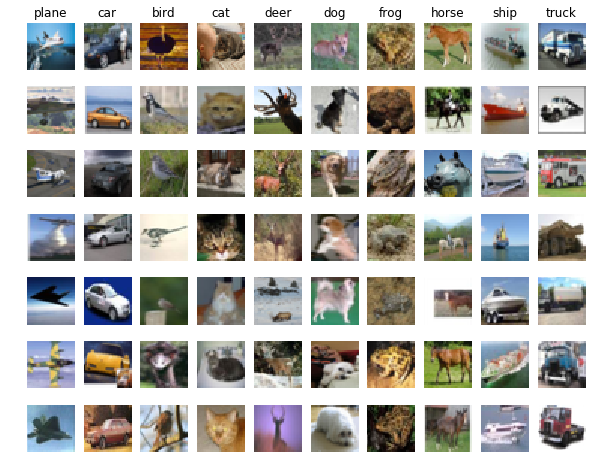

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [1]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer", dtype='int32')

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GRID K520 (0000:00:03.0)


In [3]:
# for the larger networks (n>=9), we need to adjust pythons recursion limit
sys.setrecursionlimit(10000)

def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def load_data():
    xs = []
    ys = []
    for j in range(5):
      d = unpickle('./cifar10/cifar-10-batches-py/data_batch_'+`j+1`)
      x = d['data']
      y = d['labels']
      xs.append(x)
      ys.append(y)

    d = unpickle('./cifar10/cifar-10-batches-py/test_batch')
    xs.append(d['data'])
    ys.append(d['labels'])

    x = np.concatenate(xs)/np.float32(255)
    y = np.concatenate(ys)
    x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))
    x = x.reshape((x.shape[0], 32, 32, 3)).transpose(0,3,1,2)

    # subtract per-pixel mean
    pixel_mean = np.mean(x[0:50000],axis=0)
    #pickle.dump(pixel_mean, open("cifar10-pixel_mean.pkl","wb"))
    x -= pixel_mean

    # create mirrored images
    X_train = x[0:50000,:,:,:]
    Y_train = y[0:50000]
    X_train_flip = X_train[:,:,:,::-1]
    Y_train_flip = Y_train
    X_train = np.concatenate((X_train,X_train_flip),axis=0)
    Y_train = np.concatenate((Y_train,Y_train_flip),axis=0)

    X_test = x[50000:,:,:,:]
    Y_test = y[50000:]

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        Y_train=Y_train.astype('int32'),
        X_test = lasagne.utils.floatX(X_test),
        Y_test = Y_test.astype('int32'),)


print("Loading data...")
data = load_data()
X_train = data['X_train']
y_train = data['Y_train']
X_test = data['X_test']
y_test = data['Y_test']
print("Done")

Loading data...
Done


<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Стали глубже, больше слоёв.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Долго учится, нехватка данных для качественного обучения.

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить?

Маленький датасет, нужно применить различные методы аугментации данных - поворачивать картинки, вырезать некоторые области на картинке - иными словами, надо расширить датасет.

**Вопрос 4**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 5**: Как сделать стайл трансфер для музыки? oO

Аудио-файл можно представить в виде его спектрограммы - это изображение. И можно попробовать применить методы из стайл трансферинга для картинок. Т.е. находить какие-то закономерности/структуру на одной "картинке" и переносить на другую "картинку" - гистограмму.

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- http://www.robots.ox.ac.uk/~vgg/research/very_deep/
- https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Wish you get fun :)

In [4]:
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.layers import PadLayer
from lasagne.layers import ExpressionLayer
from lasagne.layers import NonlinearityLayer
from lasagne.nonlinearities import softmax, rectify
from lasagne.layers import batch_norm

def build_cnn(input_var=None, n=5):
    
    # create a residual learning building block with two stacked 3x3 convlayers as in paper
    def residual_block(l, increase_dim=False, projection=False):
        input_num_filters = l.output_shape[1]
        if increase_dim:
            first_stride = (2,2)
            out_num_filters = input_num_filters*2
        else:
            first_stride = (1,1)
            out_num_filters = input_num_filters

        stack_1 = batch_norm(ConvLayer(l, num_filters=out_num_filters, filter_size=(3,3), stride=first_stride, nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
        stack_2 = batch_norm(ConvLayer(stack_1, num_filters=out_num_filters, filter_size=(3,3), stride=(1,1), nonlinearity=None, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
        
        # add shortcut connections
        if increase_dim:
            if projection:
                # projection shortcut, as option B in paper
                projection = batch_norm(ConvLayer(l, num_filters=out_num_filters, filter_size=(1,1), stride=(2,2), nonlinearity=None, pad='same', b=None, flip_filters=False))
                block = NonlinearityLayer(ElemwiseSumLayer([stack_2, projection]),nonlinearity=rectify)
            else:
                # identity shortcut, as option A in paper
                identity = ExpressionLayer(l, lambda X: X[:, :, ::2, ::2], lambda s: (s[0], s[1], s[2]//2, s[3]//2))
                padding = PadLayer(identity, [out_num_filters//4,0,0], batch_ndim=1)
                block = NonlinearityLayer(ElemwiseSumLayer([stack_2, padding]),nonlinearity=rectify)
        else:
            block = NonlinearityLayer(ElemwiseSumLayer([stack_2, l]),nonlinearity=rectify)
        
        return block

    # Building the network
    l_in = InputLayer(shape=(None, 3, 32, 32), input_var=input_var)

    # first layer, output is 16 x 32 x 32
    l = batch_norm(ConvLayer(l_in, num_filters=16, filter_size=(3,3), stride=(1,1), nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
    
    # first stack of residual blocks, output is 16 x 32 x 32
    for _ in range(n):
        l = residual_block(l)

    # second stack of residual blocks, output is 32 x 16 x 16
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)

    # third stack of residual blocks, output is 64 x 8 x 8
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)
    
    # average pooling
    l = GlobalPoolLayer(l)

    # fully connected layer
    network = DenseLayer(
            l, num_units=10,
            W=lasagne.init.HeNormal(),
            nonlinearity=softmax)

    return network

n = 6
net = build_cnn(input_X, n)

In [5]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net)
print all_weights

[W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta

In [6]:
%%time
# Loss
all_layers = lasagne.layers.get_all_layers(net)
l2_penalty = lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0001
loss = l2_penalty + lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

# Accuracy
params = lasagne.layers.get_all_params(net, trainable=True)
lr = 0.1
sh_lr = theano.shared(lasagne.utils.floatX(lr))
updates = lasagne.updates.momentum(loss, params, learning_rate=sh_lr, momentum=0.9)

test_prediction = lasagne.layers.get_output(net, deterministic=True)
accuracy = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_y), dtype=theano.config.floatX)

CPU times: user 4 s, sys: 60 ms, total: 4.06 s
Wall time: 4.04 s


In [7]:
%%time
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X, target_y], accuracy, allow_input_downcast=True)

CPU times: user 1min 18s, sys: 1.08 s, total: 1min 19s
Wall time: 1min 22s


### Вот и всё, пошли её учить

In [8]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

# Процесс обучения

In [ ]:
num_epochs = 100 #количество проходов по данным

print('Start learning...')

for epoch in range(num_epochs):
    # shuffle training data
    train_indices = np.arange(100000)
    np.random.shuffle(train_indices)
    X_train = X_train[train_indices,:,:,:]
    y_train = y_train[train_indices]

    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 128, shuffle=True, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    
    if (epoch + 1) == 41 or (epoch + 1) == 61:
        new_lr = sh_lr.get_value() * 0.1
        print("New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

Start learning...


/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


Epoch 1 of 100 took 301.357s
  training loss (in-iteration):		2.259818
  train accuracy:		31.90 %
  validation accuracy:		45.59 %
Epoch 2 of 100 took 301.341s
  training loss (in-iteration):		1.508054
  train accuracy:		54.80 %
  validation accuracy:		63.89 %


In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 